In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
import statistics

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 32
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_val_dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)
test_dataset = datasets.CIFAR10('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def plot_graph(training_losses,val_losses,epochs,string):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.title(string + 'per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(string)

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32,64 ,3)
        self.conv3 = nn.Conv2d(64,128,3)

        self.fc1 = nn.Linear(86528, 128)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(128,64)
        self.fc2_drop = nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        #x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)

        self.fc1 = nn.Linear(1536, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        #x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [6]:
model1 = Classifier().cuda()
#optimizer = optim.ASGD(model1.parameters(),lr=0.01)
optimizer = optim.Adagrad(model1.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model1.train()
    train_epoch_loss = 0
    train_correct = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        class_train_output = model1(images)
        loss = criterion(class_train_output,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = class_train_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))
    
    #validate
    model1.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            class_val_output = model1(images)
            loss = criterion(class_val_output,labels)
            val_epoch_loss += loss.item()
            pred = class_val_output.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 2.2154, Training Accuracy: 9582/40000 (24%)
Average validation loss: 1.7392, Testing Accuracy: 3750/10000 (38%)
Epoch 1
Average training loss: 1.7277, Training Accuracy: 14402/40000 (36%)
Average validation loss: 1.5345, Testing Accuracy: 4499/10000 (45%)
Epoch 2
Average training loss: 1.5807, Training Accuracy: 17117/40000 (43%)
Average validation loss: 1.3884, Testing Accuracy: 5076/10000 (51%)
Epoch 3
Average training loss: 1.4774, Training Accuracy: 18923/40000 (47%)
Average validation loss: 1.3178, Testing Accuracy: 5369/10000 (54%)
Epoch 4
Average training loss: 1.4013, Training Accuracy: 20057/40000 (50%)
Average validation loss: 1.2513, Testing Accuracy: 5614/10000 (56%)
Epoch 5
Average training loss: 1.3236, Training Accuracy: 21153/40000 (53%)
Average validation loss: 1.1785, Testing Accuracy: 5793/10000 (58%)
Epoch 6
Average training loss: 1.2660, Training Accuracy: 22166/40000 (55%)
Average validation loss: 1.1607, Testing Accuracy: 5874/10000

Lowest validation loss 0.9567712173340427
Lowest training loss 0.16181962128281593
Average test loss: 1.5036, Testing Accuracy: 6926/10000 (69%)


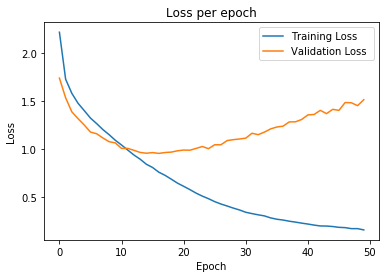

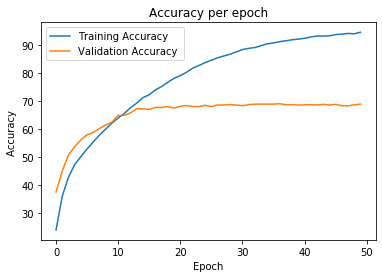

In [7]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
print("Lowest validation loss", min(val_losses))
print("Lowest training loss", min(training_losses))
model1.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    class_test_output = model1(images)
    loss = criterion(class_test_output,labels)
    test_epoch_loss += loss.item()
    pred = class_test_output.max(1, keepdim=True)[1] # get the index of the max log-probability
    test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
    test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32,64 ,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.deconv1 = nn.ConvTranspose2d(128,64,3)
        self.deconv2 = nn.ConvTranspose2d(64,32,3)
        self.deconv3 = nn.ConvTranspose2d(32,3,3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        encoded = F.relu(self.conv3(x))
        decoded = F.relu(self.deconv1(encoded))
        decoded = F.relu(self.deconv2(decoded))
        decoded = F.relu(self.deconv3(decoded))
        return torch.sigmoid(decoded)

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        encoded = F.leaky_relu(self.conv2(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        return torch.sigmoid(decoded)

In [9]:
model2 = AutoEncoder().cuda()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.ASGD(model2.parameters(),lr=0.01)
#optimizer = optim.Adagrad(model2.parameters(),lr=0.01)
#optimizer = optim.Adam(model2.parameters(),lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model2.train()
    train_epoch_loss = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        auto_train_output = model2(images)
        loss = criterion(auto_train_output,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)
    
    #validate
    model2.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            auto_val_output = model2(images)
            loss = criterion(auto_val_output,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print('Average testing loss: {:.4f}'.format(val_epoch_loss))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.06393144132494927
Average testing loss: 0.0642
Epoch 1
Average training loss: 0.06393144118189811
Average testing loss: 0.0642
Epoch 2
Average training loss: 0.06393144117593766
Average testing loss: 0.0642
Epoch 3
Average training loss: 0.06393144112229347
Average testing loss: 0.0642
Epoch 4
Average training loss: 0.0639314411997795
Average testing loss: 0.0642
Epoch 5
Average training loss: 0.06393144115805625
Average testing loss: 0.0642
Epoch 6
Average training loss: 0.063931441116333
Average testing loss: 0.0642
Epoch 7


KeyboardInterrupt: ignored

Average testing loss: 0.0413


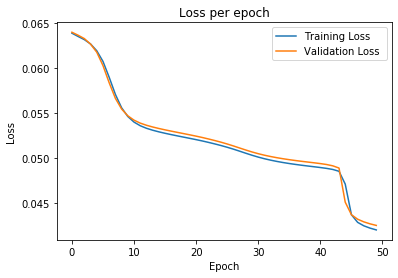

In [7]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model2.eval()
test_epoch_loss = 0
with torch.no_grad():
      for images, labels in testloader:
          images, labels = images.cuda(), labels.cuda()
          auto_test_output = model2(images)
          loss = criterion(auto_test_output,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}'.format(test_epoch_loss))

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


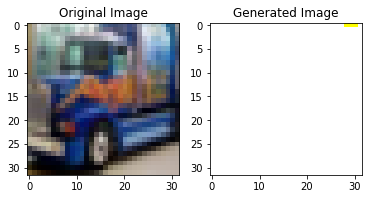

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


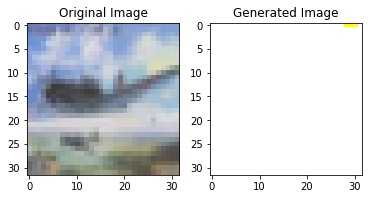

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


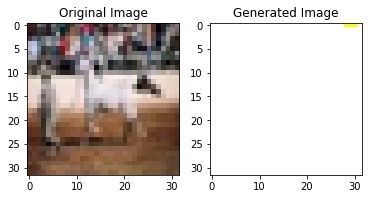

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


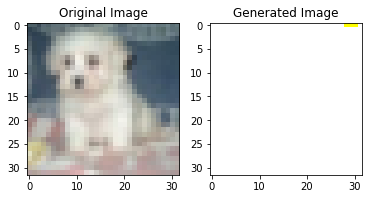

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


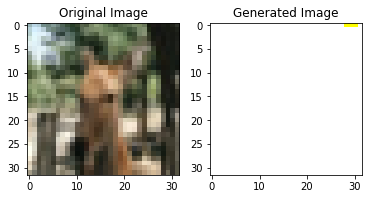

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


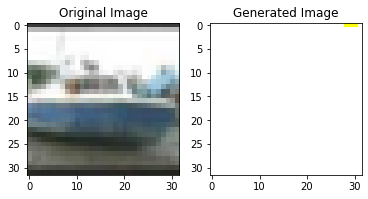

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


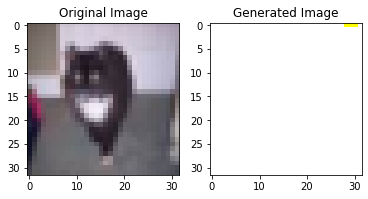

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


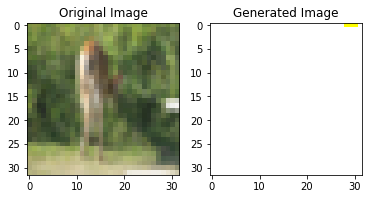

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


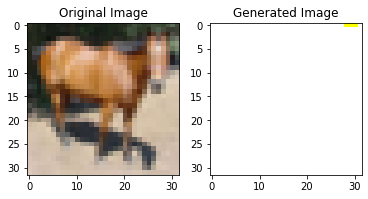

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


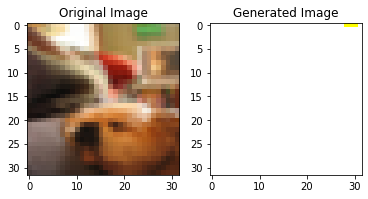

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


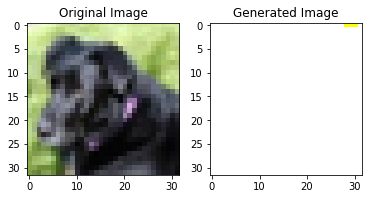

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


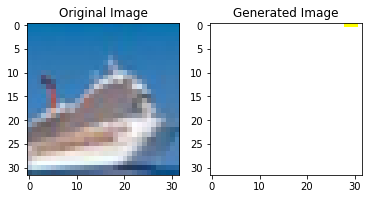

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


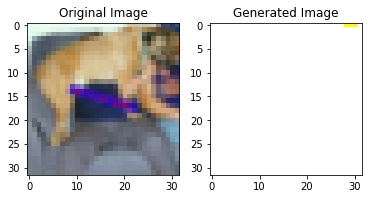

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


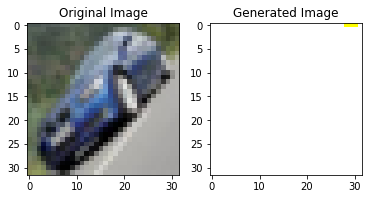

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


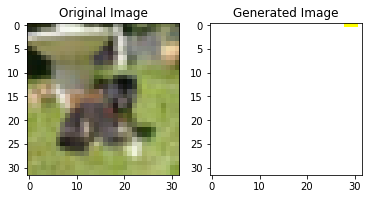

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


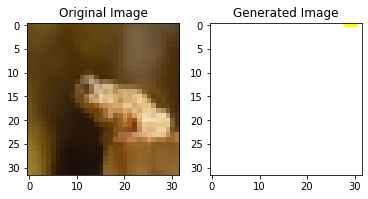

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


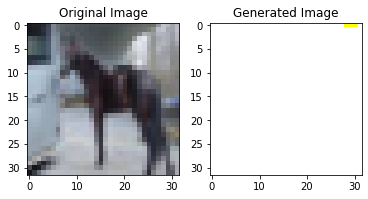

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


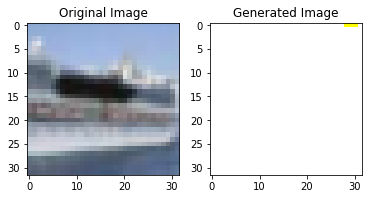

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


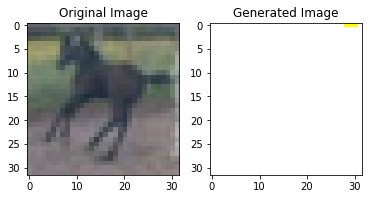

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


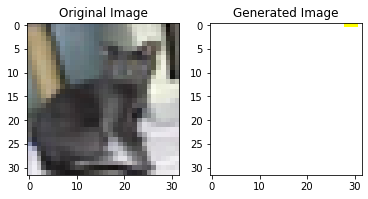

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


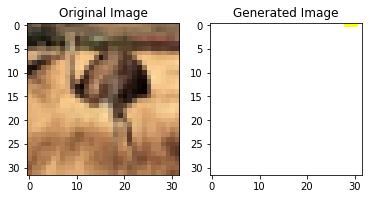

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


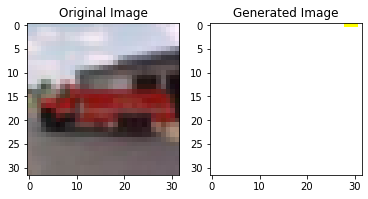

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


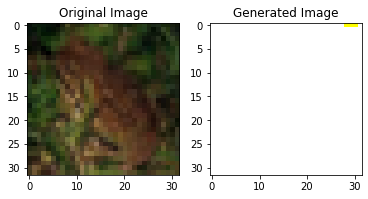

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


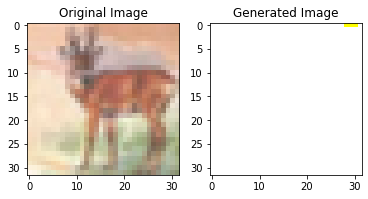

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


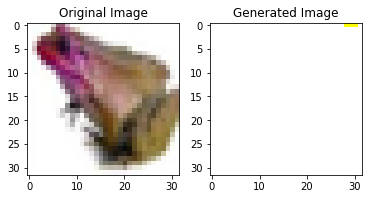

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


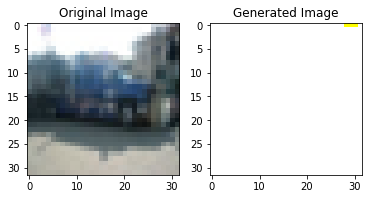

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


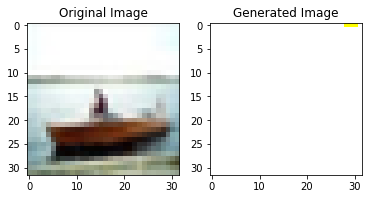

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


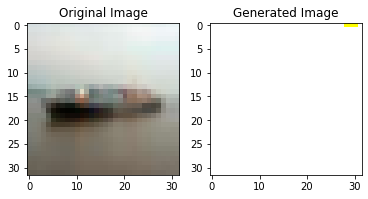

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


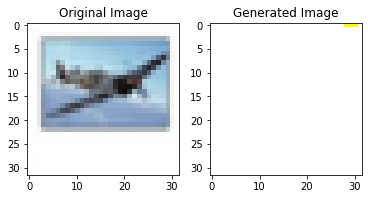

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


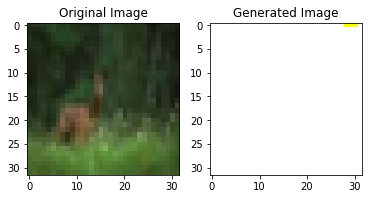

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


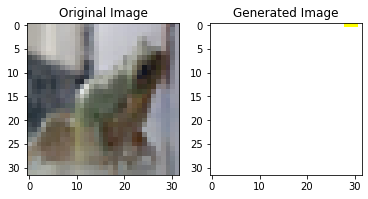

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


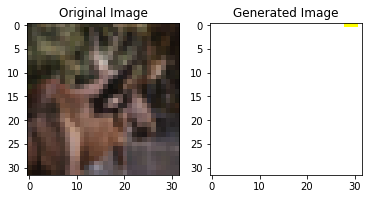

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


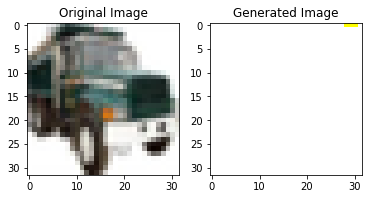

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


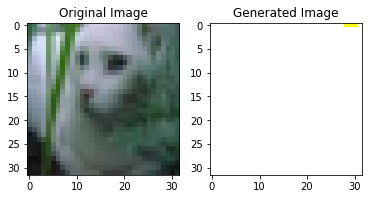

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


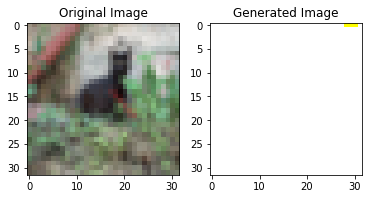

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


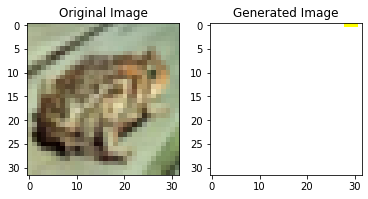

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


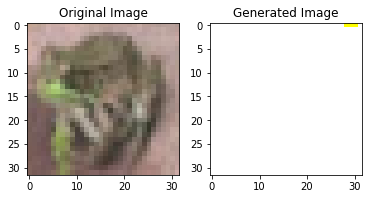

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


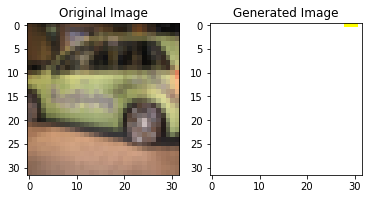

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


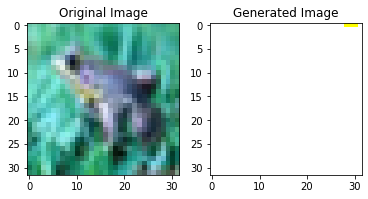

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


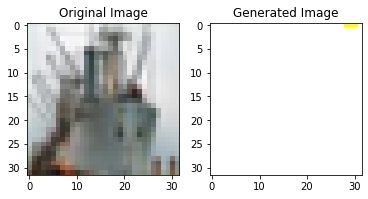

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


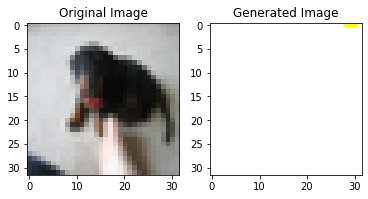

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


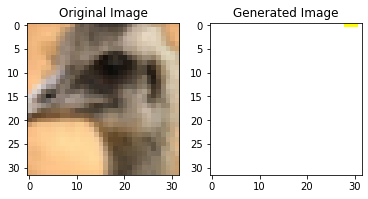

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


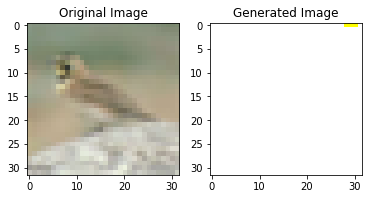

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


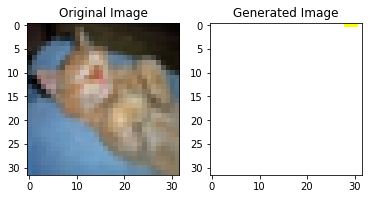

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


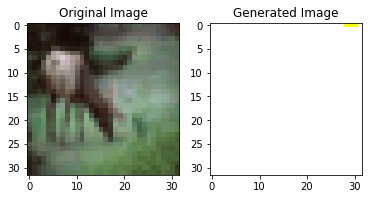

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


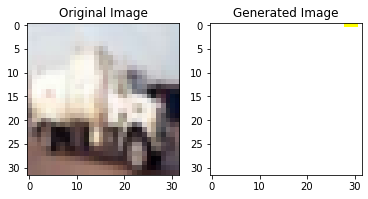

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


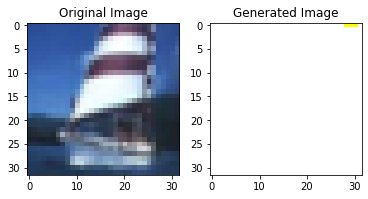

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


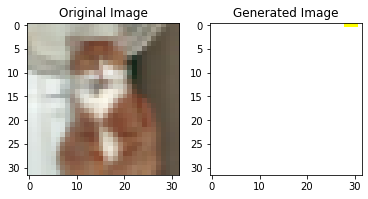

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


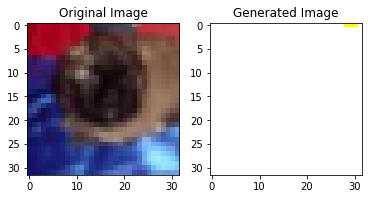

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


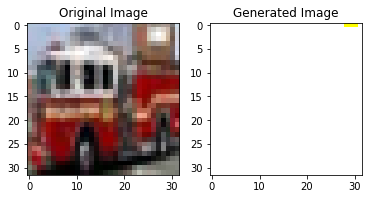

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


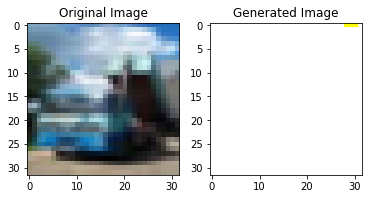

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


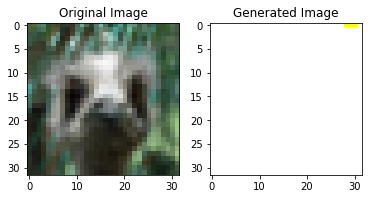

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


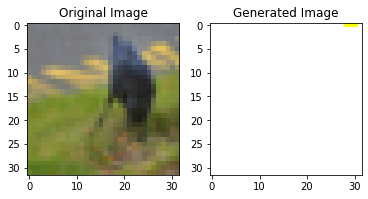

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


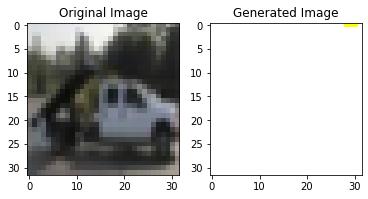

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


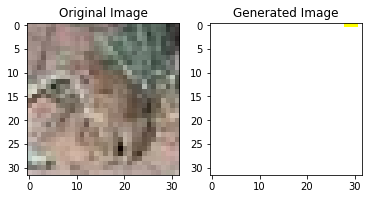

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


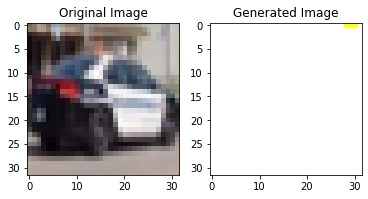

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


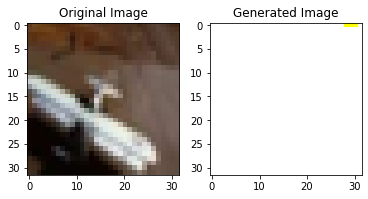

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


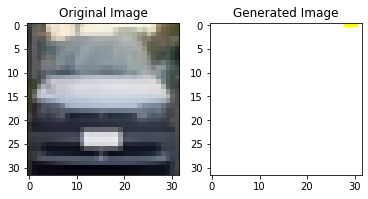

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


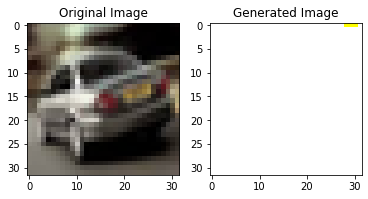

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


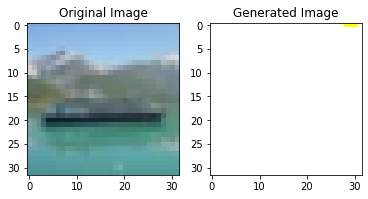

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


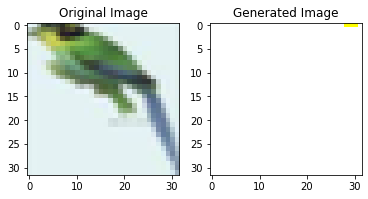

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


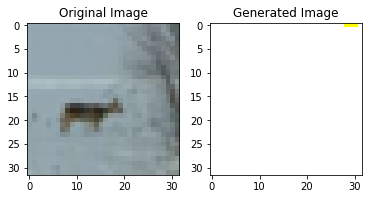

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


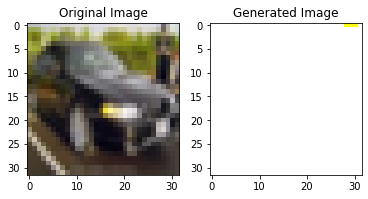

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


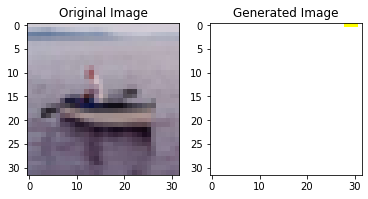

In [7]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model2(test_images)
#noisy_test_imgs = test_images + 0.1 * torch.randn(*test_images.shape)
#noisy_test_imgs = np.clip(noisy_test_imgs, 0., 1.)
#noisy_test_imgs = noisy_test_imgs.cuda()
#test_output = model(noisy_test_imgs)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    print(image_input.shape)
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    print(image_input.shape)
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed model definitions

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()

        self.conv1 = nn.Conv2d(3, 32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)

        self.deconv1 = nn.ConvTranspose2d(128,64,3)
        self.deconv2 = nn.ConvTranspose2d(64,32,3)
        self.deconv3 = nn.ConvTranspose2d(32,3,3)

        self.fc1 = nn.Linear(86528, 256)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(256,64)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        encoded = F.leaky_relu(self.conv3(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        decoded = F.leaky_relu(self.deconv3(decoded))
        flattened = encoded.view(encoded.size(0),-1)
        predicted = F.leaky_relu(self.fc1_drop(self.fc1(flattened)))
        predicted = F.leaky_relu(self.fc2_drop(self.fc2(predicted)))
        predicted = self.fc3(predicted)
        return torch.sigmoid(decoded), F.log_softmax(predicted, dim=1)

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(1536, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        encoded = F.leaky_relu(self.conv2(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        flattened = encoded.view(encoded.size(0),-1)
        predicted = F.leaky_relu(self.fc1_drop(self.fc1(flattened)))
        predicted = F.leaky_relu(self.fc2_drop(self.fc2(predicted)))
        predicted = self.fc3(predicted)
        return torch.sigmoid(decoded), F.log_softmax(predicted, dim=1)

# Mixed (autoencoder loss)

In [13]:
model3 = Mixed().to(device)
#optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model3.parameters(),lr=0.01)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model3.train()
    train_epoch_loss = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_auto_train_mixed,predicted = model3(images)
        loss = criterion1(decoded_auto_train_mixed,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)

    #validate
    model3.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_auto_val_mixed, predicted = model3(images)
            loss = criterion1(decoded_auto_val_mixed,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print("Average validation loss:",val_epoch_loss)
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.012069039390236139
Average validation loss: 0.004075002327122411
Epoch 1
Average training loss: 0.003330118373781443
Average validation loss: 0.002791808124714691
Epoch 2
Average training loss: 0.002433491626009345
Average validation loss: 0.0017768368295506592
Epoch 3
Average training loss: 0.0015848490314558149
Average validation loss: 0.0014555222127930658
Epoch 4
Average training loss: 0.0013360611533746124
Average validation loss: 0.0013412464740775098
Epoch 5
Average training loss: 0.0011883349149487913
Average validation loss: 0.001073025687520576
Epoch 6
Average training loss: 0.0011074438783340156
Average validation loss: 0.0009736679127339013
Epoch 7
Average training loss: 0.0011893390126526356
Average validation loss: 0.0012389924310468089
Epoch 8
Average training loss: 0.0009632785054855048
Average validation loss: 0.0008729095478055726
Epoch 9
Average training loss: 0.0008768127990886569
Average validation loss: 0.0007697013762904105
Epoch 

Average testing loss: 0.3371071232731935


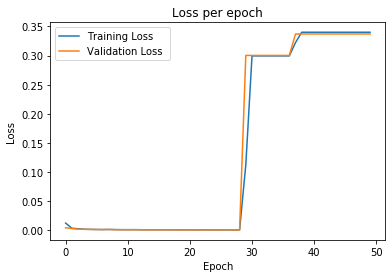

In [14]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
model3.eval()
test_epoch_loss = 0
with torch.no_grad():
    for images, labels in testloader:
          images, labels = images.cuda(),labels.cuda()
          decoded_auto_test_mixed, predicted = model3(images)
          loss = criterion1(decoded_auto_test_mixed,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print("Average testing loss:",test_epoch_loss)

In [0]:
train_mean_auto = statistics.mean(training_losses)
val_mean_auto = statistics.mean(val_losses)
train_std_auto = statistics.stdev(training_losses)
val_std_auto = statistics.stdev(val_losses)

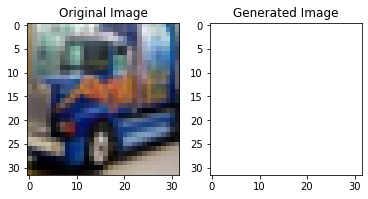

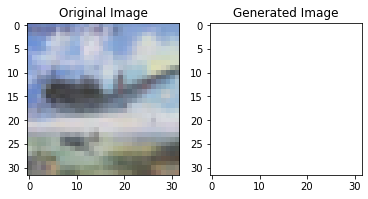

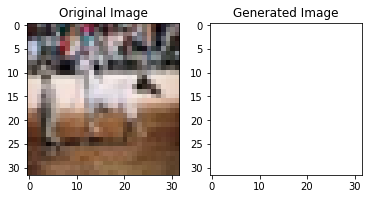

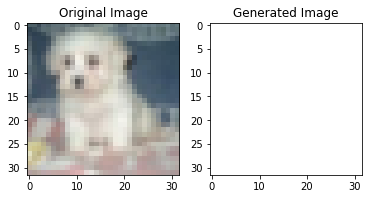

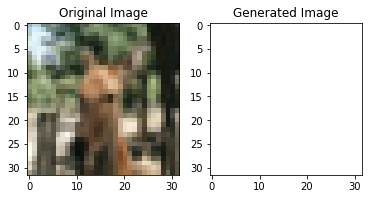

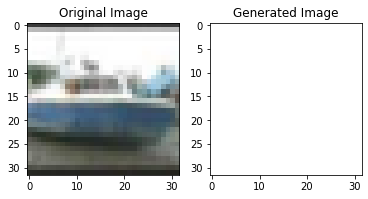

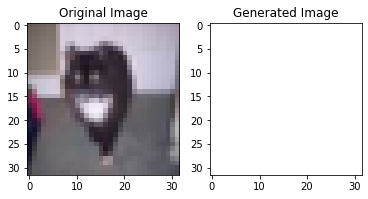

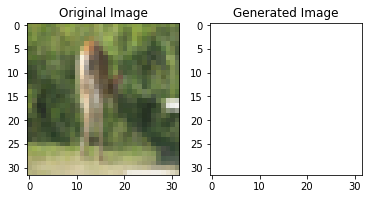

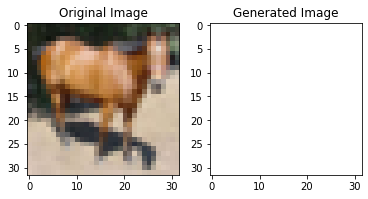

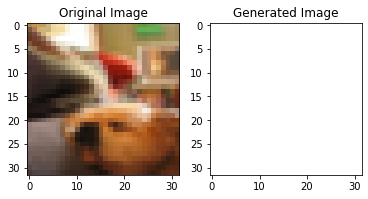

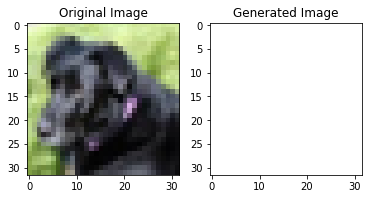

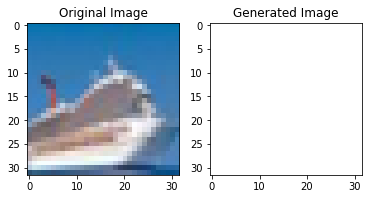

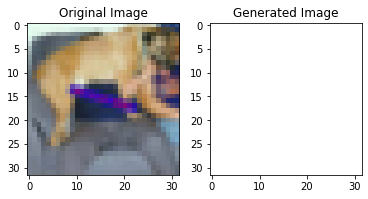

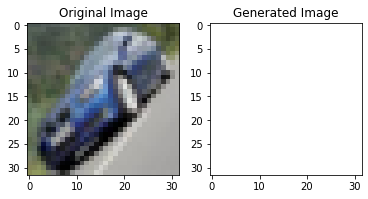

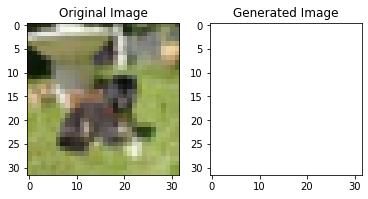

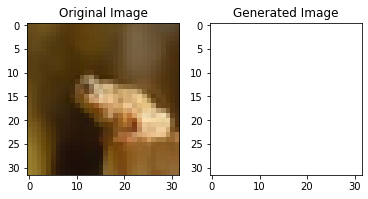

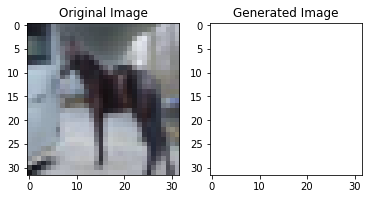

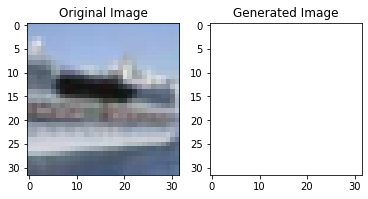

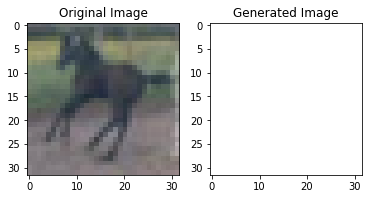

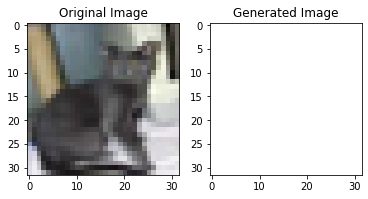

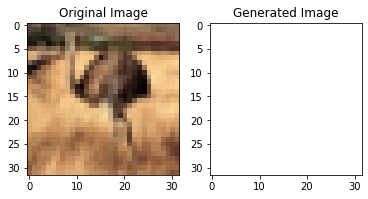

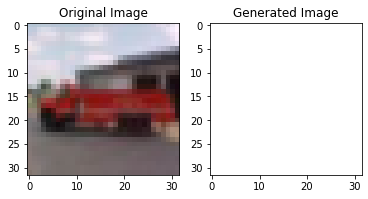

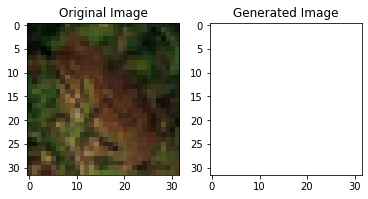

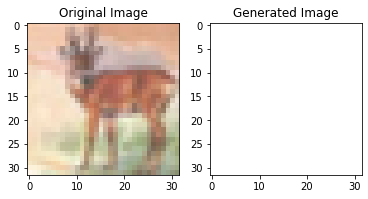

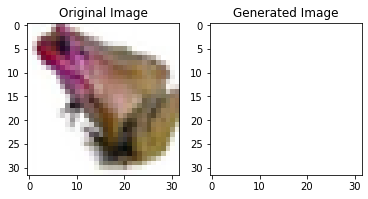

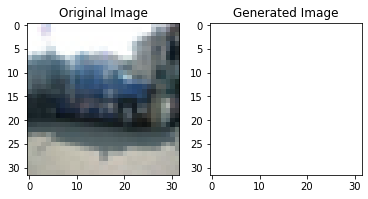

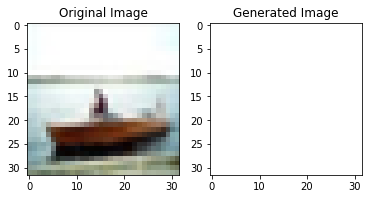

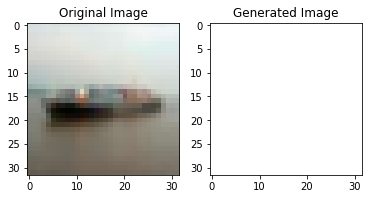

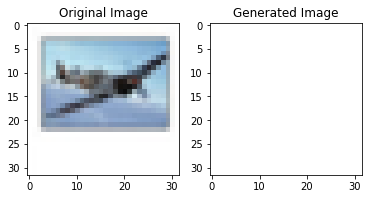

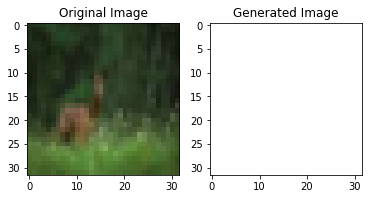

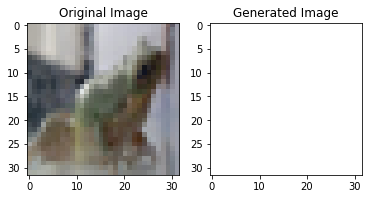

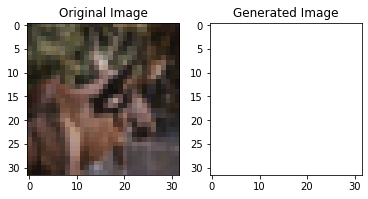

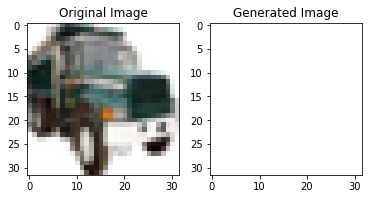

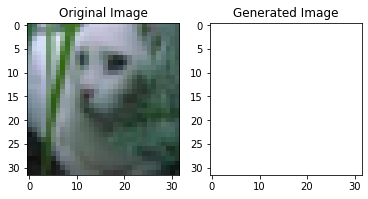

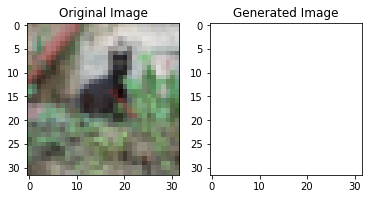

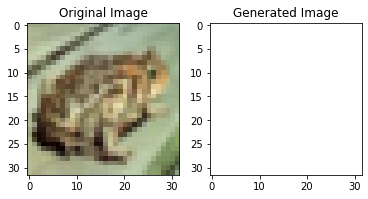

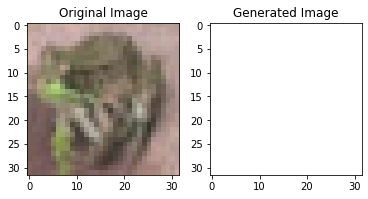

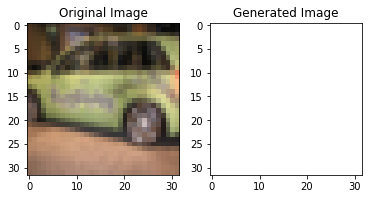

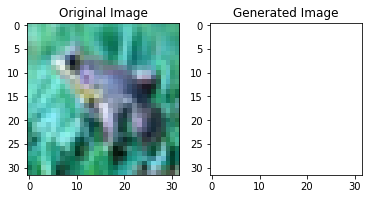

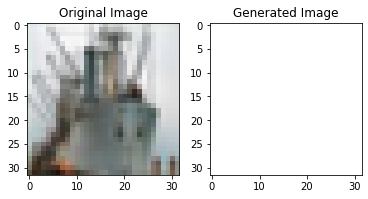

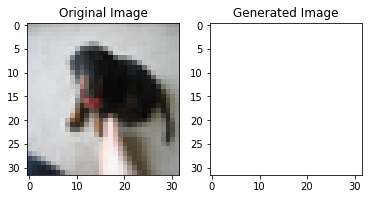

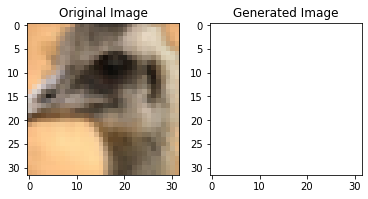

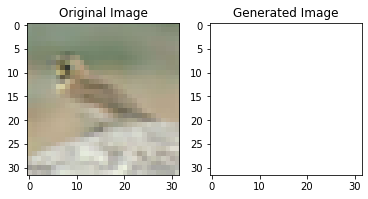

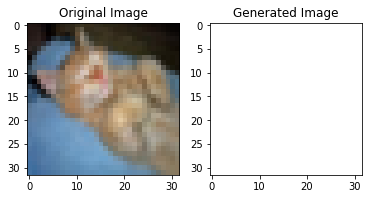

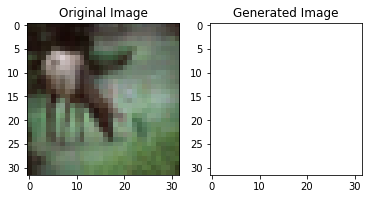

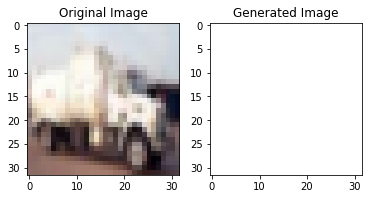

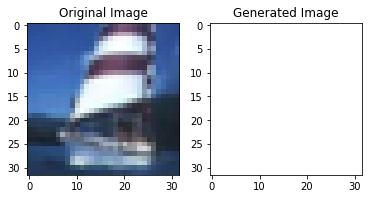

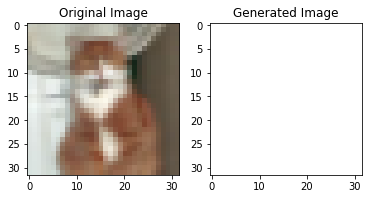

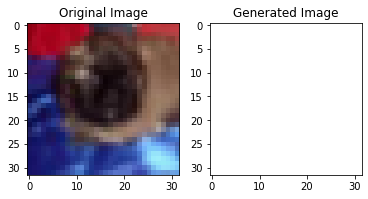

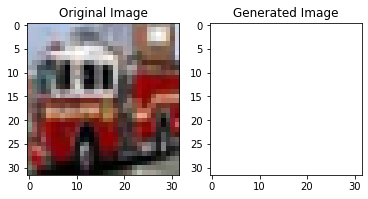

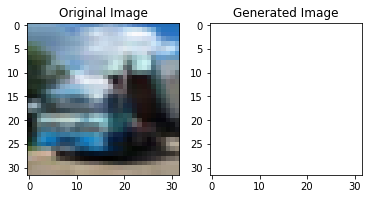

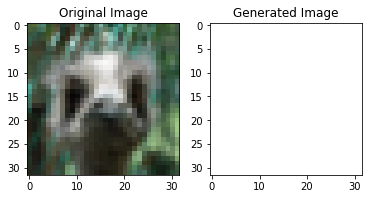

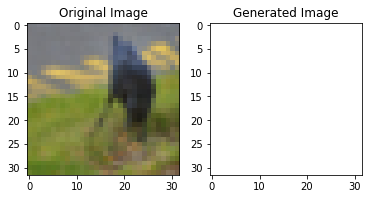

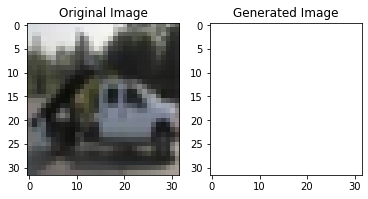

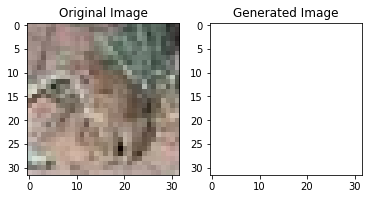

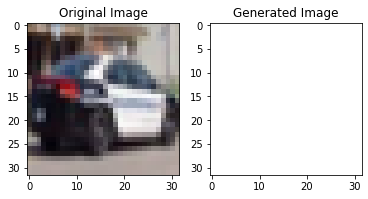

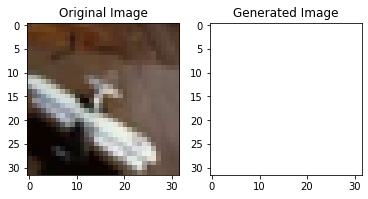

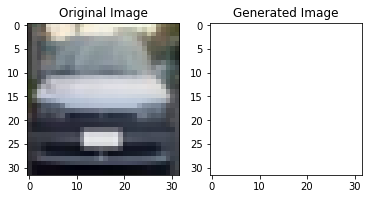

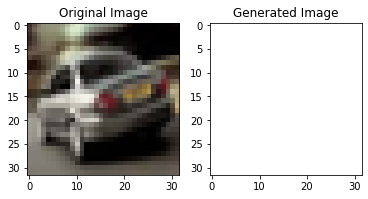

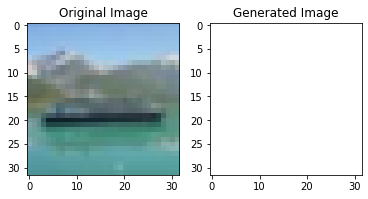

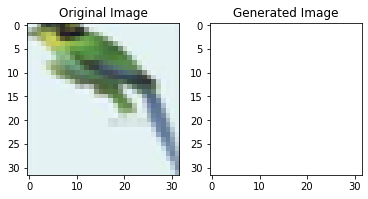

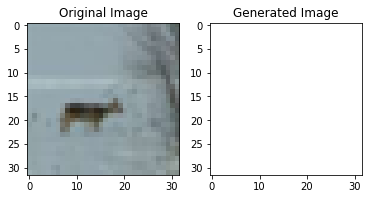

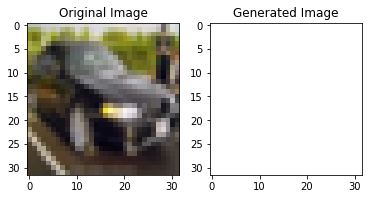

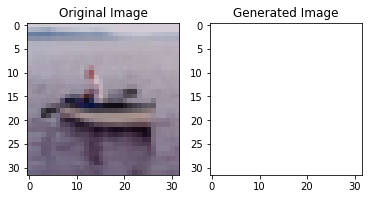

In [16]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model3(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed (classifier loss)

In [17]:
model4 = Mixed().to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model4.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model4.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model4(images)
        loss = criterion2(predicted,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model4.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 2.0816, Training Accuracy: 8871/40000 (22%)
Average validation loss: 1.7870, Validation Accuracy: 3352/10000 (34%)
Epoch 1
Average training loss: 1.7935, Training Accuracy: 13830/40000 (35%)
Average validation loss: 1.5357, Validation Accuracy: 4376/10000 (44%)
Epoch 2
Average training loss: 1.6065, Training Accuracy: 16500/40000 (41%)
Average validation loss: 1.4300, Validation Accuracy: 4681/10000 (47%)
Epoch 3
Average training loss: 1.4803, Training Accuracy: 18671/40000 (47%)
Average validation loss: 1.3244, Validation Accuracy: 5235/10000 (52%)
Epoch 4
Average training loss: 1.3480, Training Accuracy: 20642/40000 (52%)
Average validation loss: 1.2126, Validation Accuracy: 5638/10000 (56%)
Epoch 5
Average training loss: 1.2468, Training Accuracy: 22374/40000 (56%)
Average validation loss: 1.1401, Validation Accuracy: 5884/10000 (59%)
Epoch 6
Average training loss: 1.1204, Training Accuracy: 24297/40000 (61%)
Average validation loss: 1.0520, Validation

Average validation loss: 1.8716, Validation Accuracy: 6811/10000 (68%)


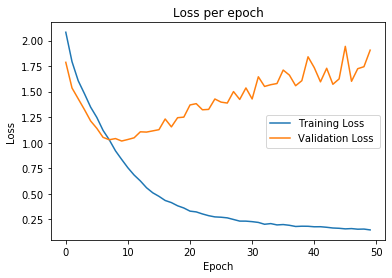

In [18]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model4.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [0]:
train_class_mean = statistics.mean(training_losses)
val_class_mean = statistics.mean(val_losses)
train_class_std = statistics.stdev(training_losses)
val_class_std = statistics.stdev(val_losses)

# Mixed (two losses - no scaling of losses, no feedback)

In [20]:
model5 = Mixed().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model5.parameters(),lr=0.01)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model5.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_train_mixed,predicted = model5(images)
        loss1 = criterion1(decoded_train_mixed,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)

    #validate
    model5.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_val_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_val_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 2.1619, Training Accuracy: 8491/40000 (21%)
Average validation loss: 1.8270, Validation Accuracy: 3535/10000 (35%)
Epoch 1
Average training loss: 1.8498, Training Accuracy: 13674/40000 (34%)
Average validation loss: 1.6711, Validation Accuracy: 4184/10000 (42%)
Epoch 2
Average training loss: 1.6614, Training Accuracy: 16539/40000 (41%)
Average validation loss: 1.4797, Validation Accuracy: 4742/10000 (47%)
Epoch 3
Average training loss: 1.5380, Training Accuracy: 18676/40000 (47%)
Average validation loss: 1.3852, Validation Accuracy: 5077/10000 (51%)
Epoch 4
Average training loss: 1.3968, Training Accuracy: 20761/40000 (52%)
Average validation loss: 1.2625, Validation Accuracy: 5659/10000 (57%)
Epoch 5
Average training loss: 1.2780, Training Accuracy: 22616/40000 (57%)
Average validation loss: 1.1756, Validation Accuracy: 6001/10000 (60%)
Epoch 6
Average training loss: 1.1626, Training Accuracy: 24386/40000 (61%)
Average validation loss: 1.1266, Validation

Average validation loss: 1.7693, Validation Accuracy: 6693/10000 (67%)


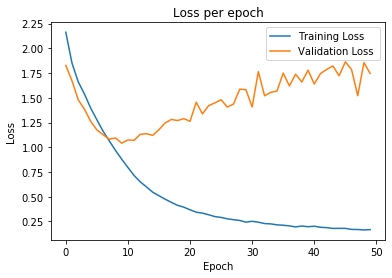

In [21]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
#plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model5.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_test_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_test_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

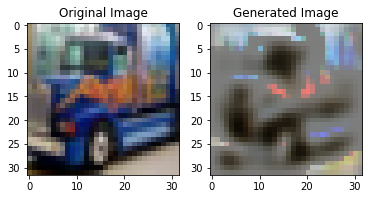

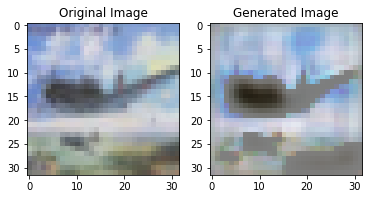

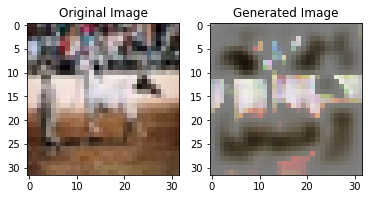

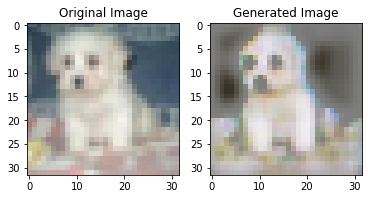

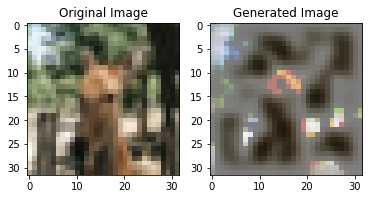

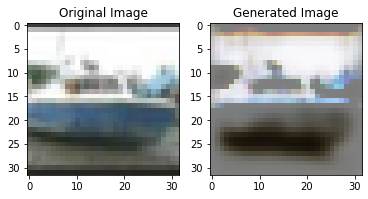

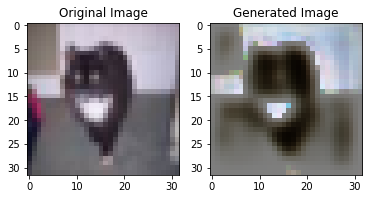

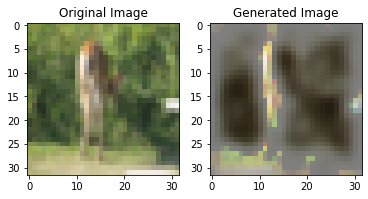

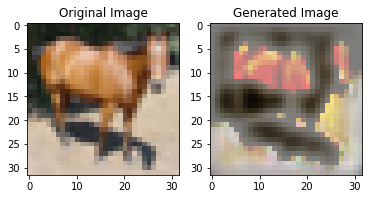

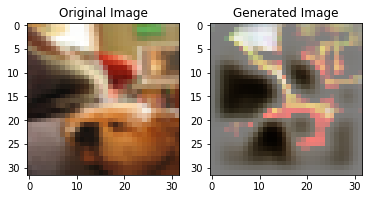

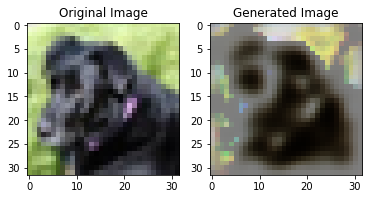

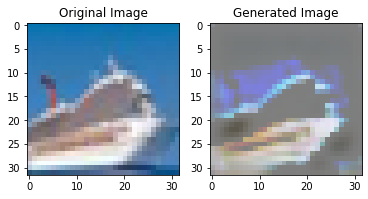

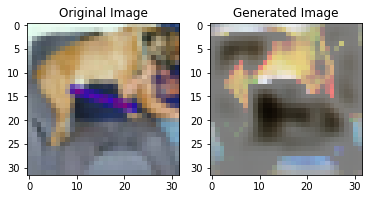

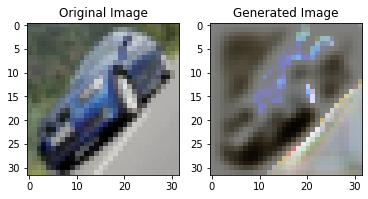

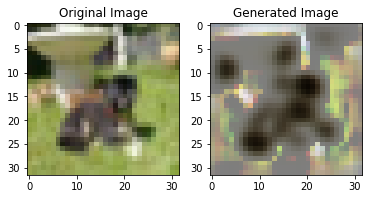

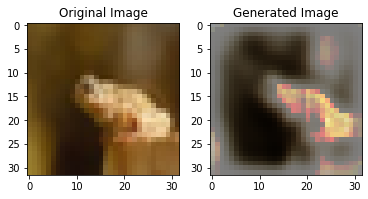

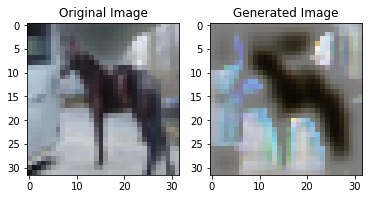

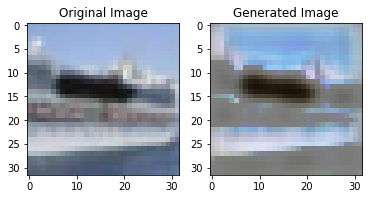

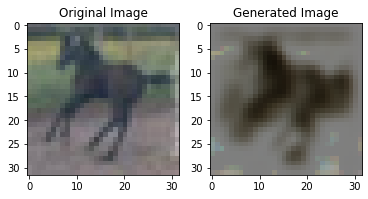

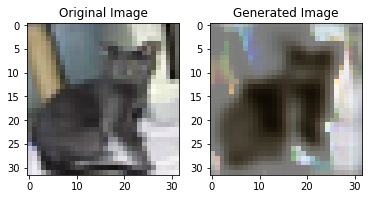

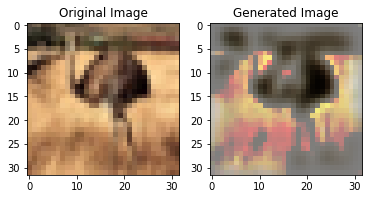

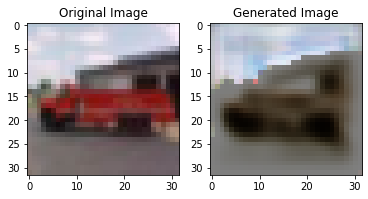

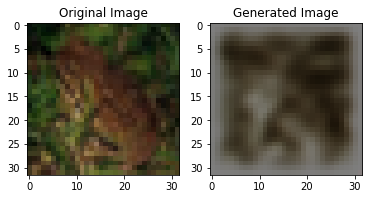

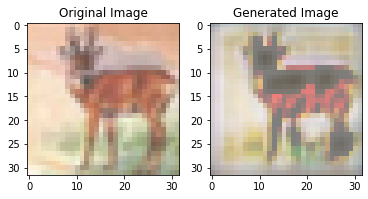

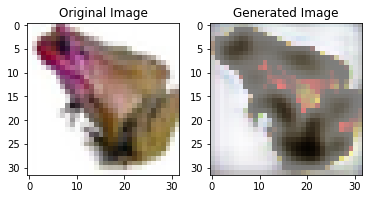

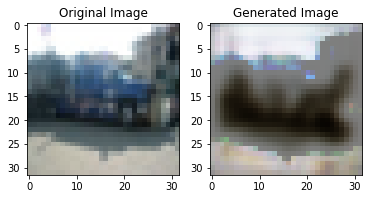

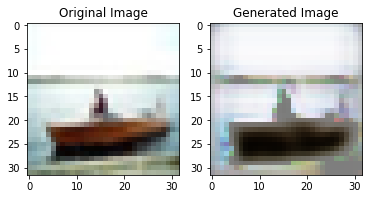

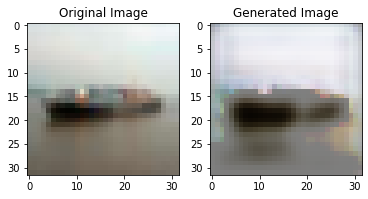

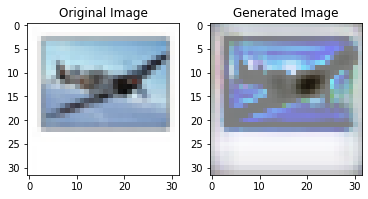

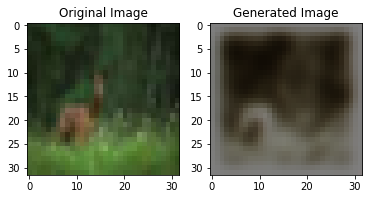

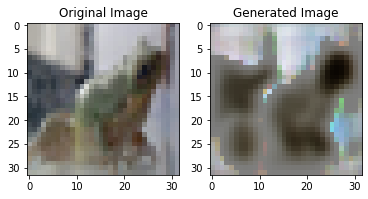

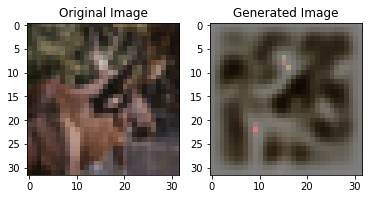

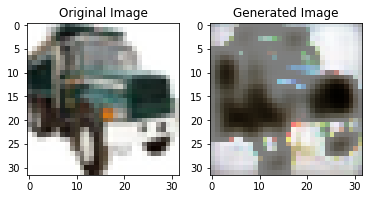

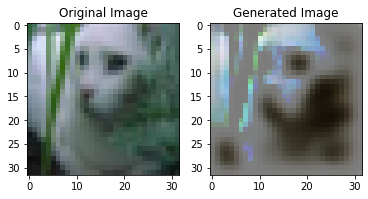

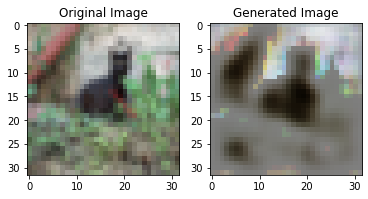

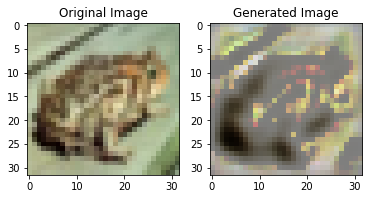

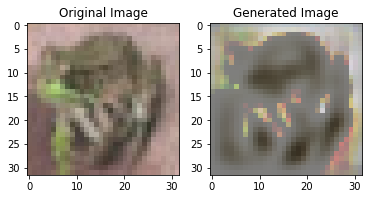

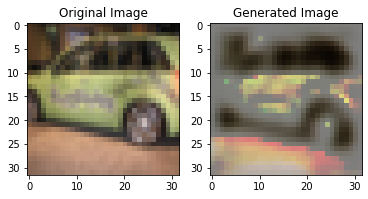

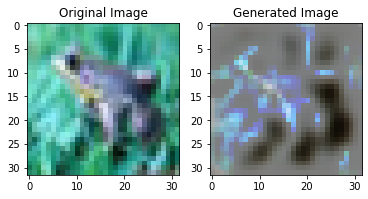

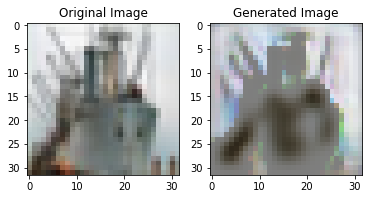

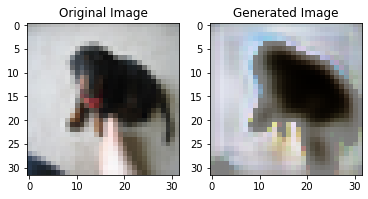

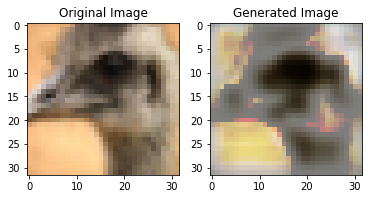

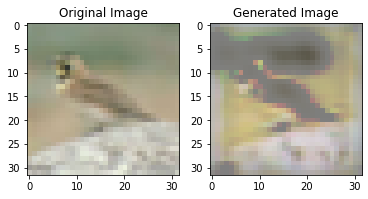

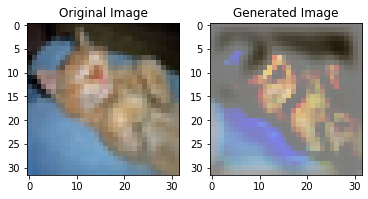

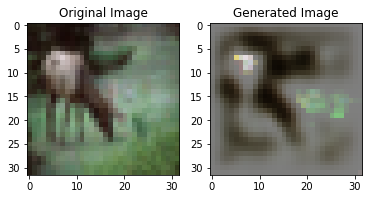

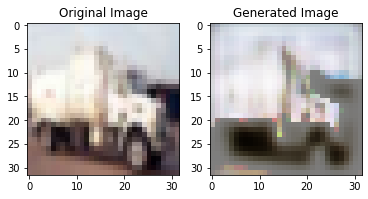

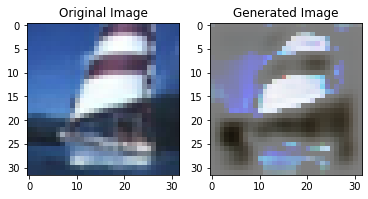

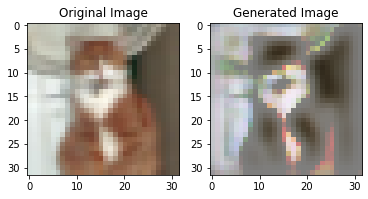

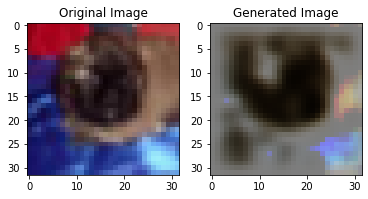

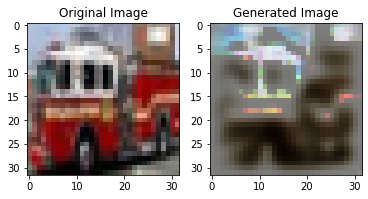

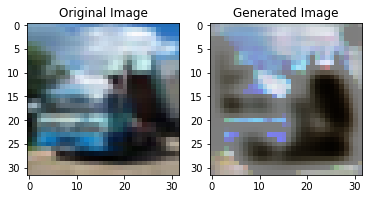

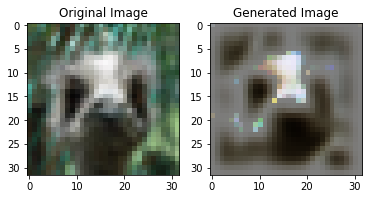

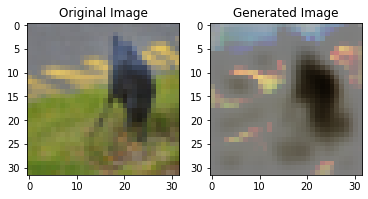

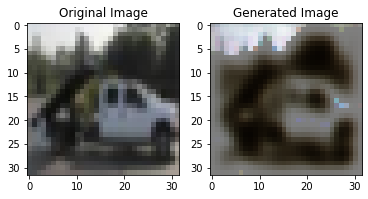

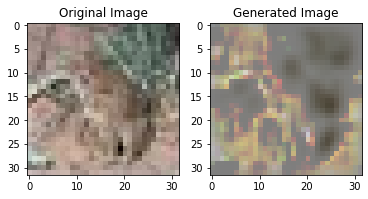

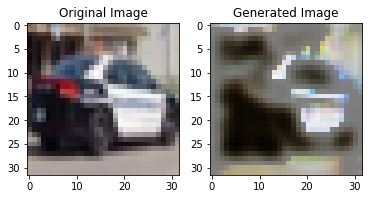

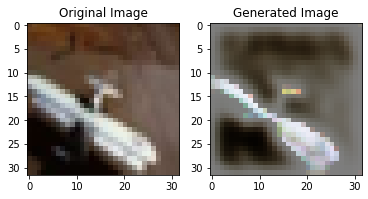

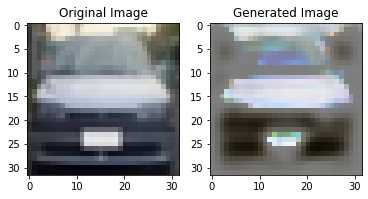

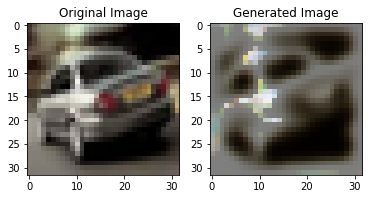

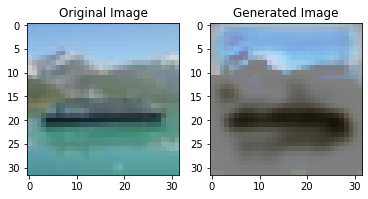

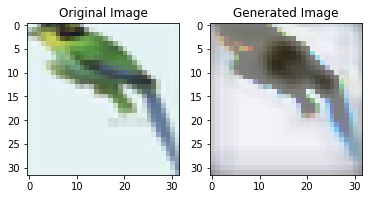

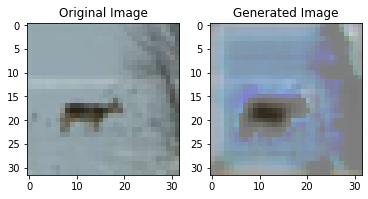

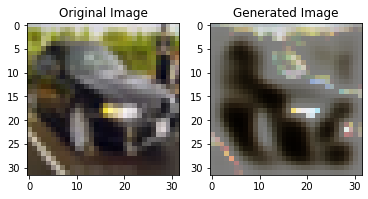

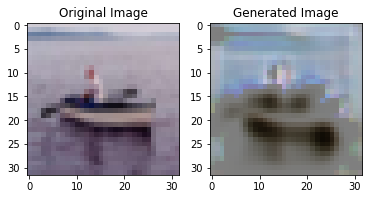

In [22]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model5(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed model - with scaling of losses

In [23]:
model7 = Mixed().to(device)
optimizer = optim.SGD(model7.parameters(),lr=0.01,momentum=0.9)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model7.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model7(images)
        loss1 = (criterion1(decoded,images)-train_mean_auto)/train_std_auto
        loss2 = (criterion2(predicted,labels)-train_class_mean)/train_class_std
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model7.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 2.7768, Training Accuracy: 8807/40000 (22%)
Average validation loss: 0.7275, Validation Accuracy: 3399/10000 (34%)
Epoch 1
Average training loss: 2.0485, Training Accuracy: 14366/40000 (36%)
Average validation loss: -0.1860, Validation Accuracy: 4322/10000 (43%)
Epoch 2
Average training loss: 1.6514, Training Accuracy: 17219/40000 (43%)
Average validation loss: -1.0113, Validation Accuracy: 5129/10000 (51%)
Epoch 3
Average training loss: 1.3029, Training Accuracy: 19432/40000 (49%)
Average validation loss: -1.4761, Validation Accuracy: 5588/10000 (56%)
Epoch 4
Average training loss: 0.9904, Training Accuracy: 21536/40000 (54%)
Average validation loss: -1.3776, Validation Accuracy: 5632/10000 (56%)
Epoch 5
Average training loss: 0.7478, Training Accuracy: 23305/40000 (58%)
Average validation loss: -1.8246, Validation Accuracy: 5947/10000 (59%)
Epoch 6
Average training loss: 0.5470, Training Accuracy: 24632/40000 (62%)
Average validation loss: -1.9199, Vali

Average testing loss: 0.4441, Testing Accuracy: 6160/10000 (62%)


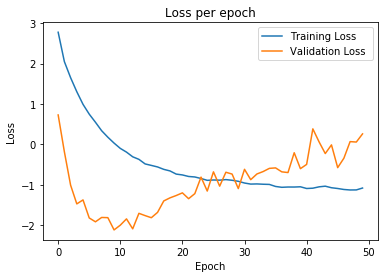

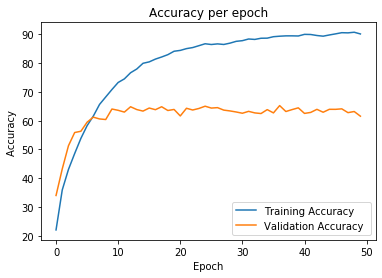

In [24]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model7.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

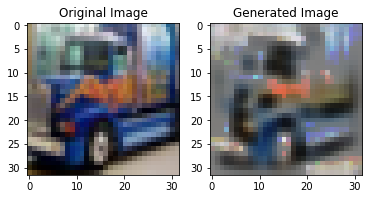

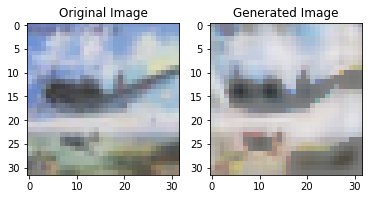

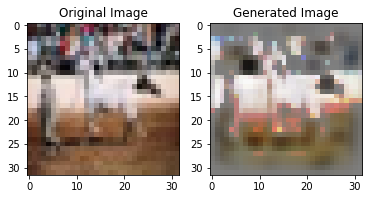

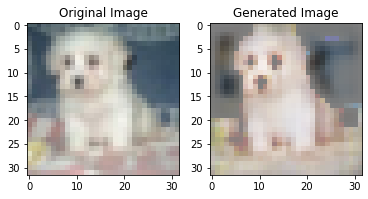

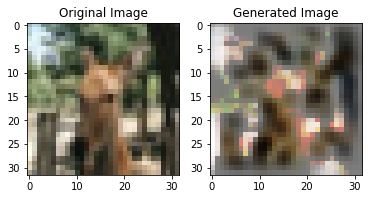

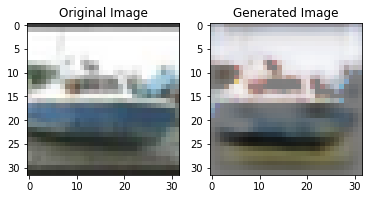

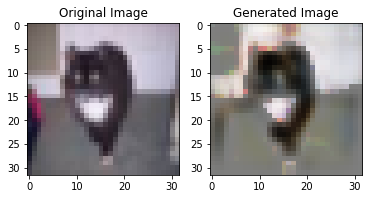

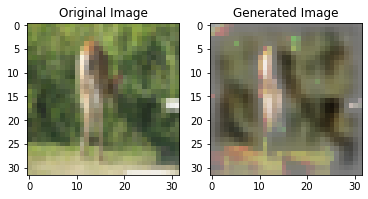

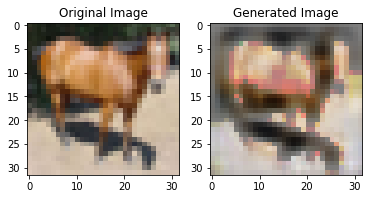

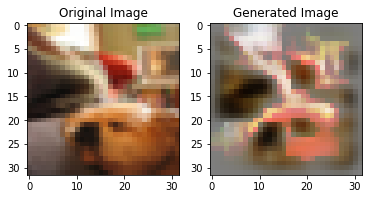

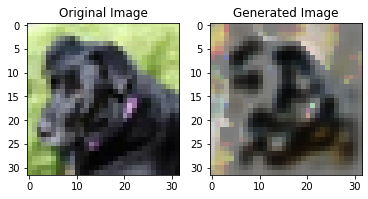

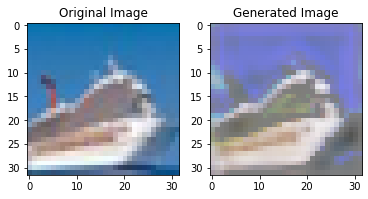

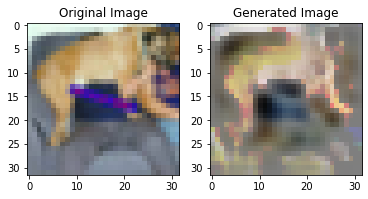

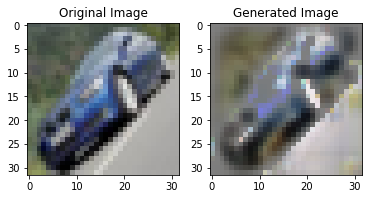

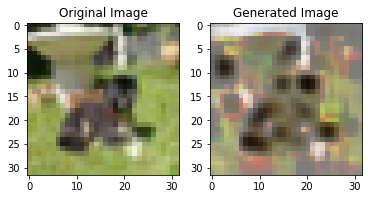

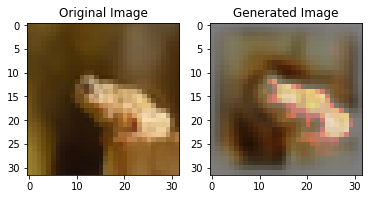

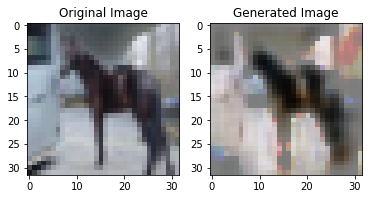

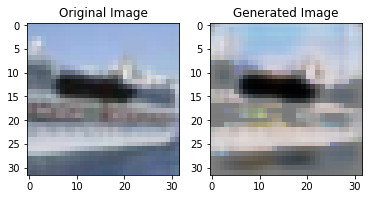

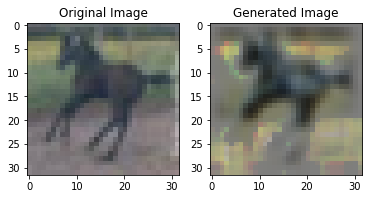

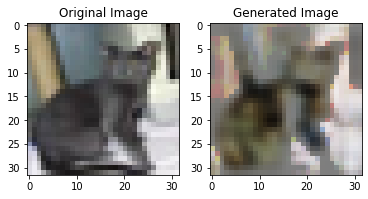

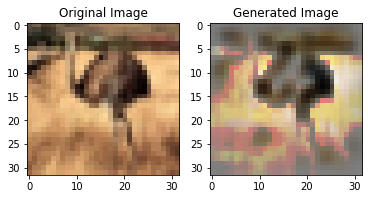

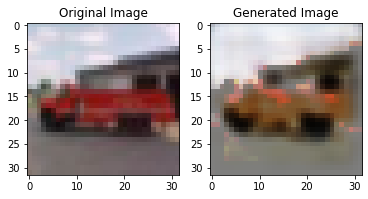

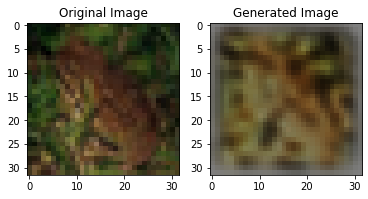

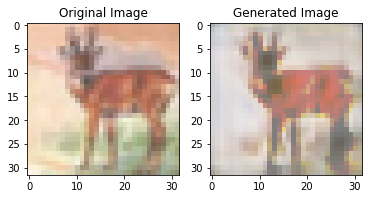

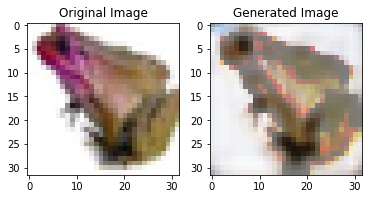

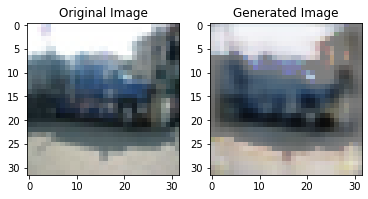

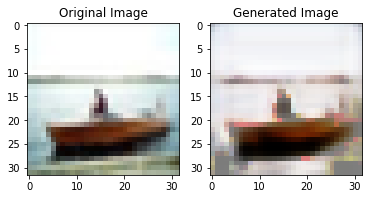

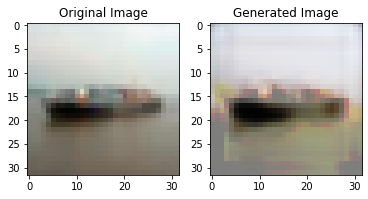

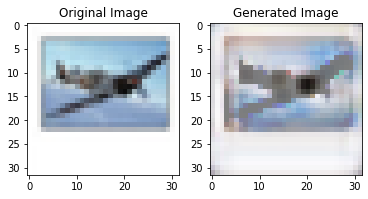

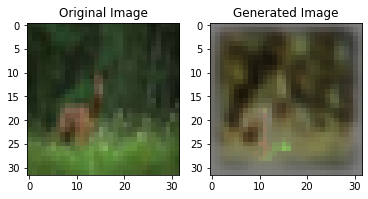

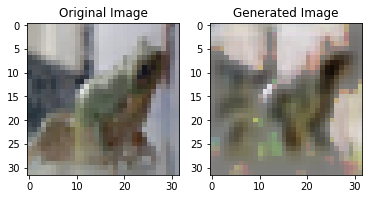

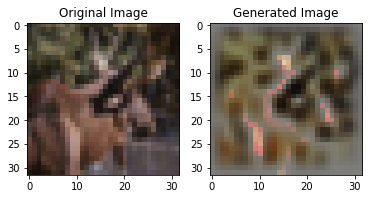

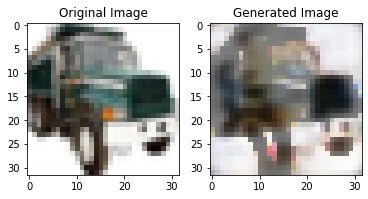

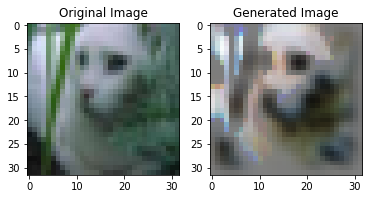

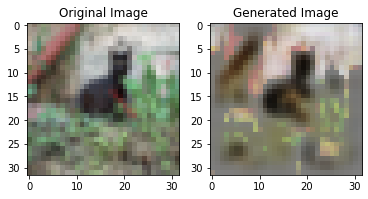

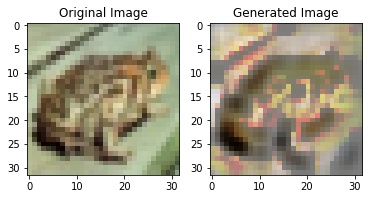

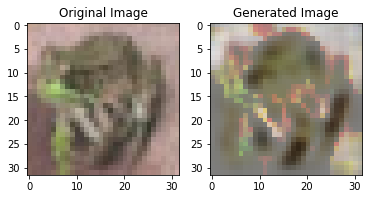

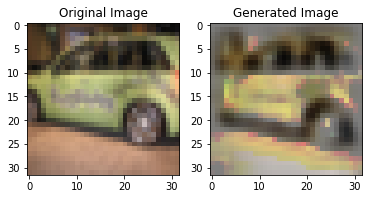

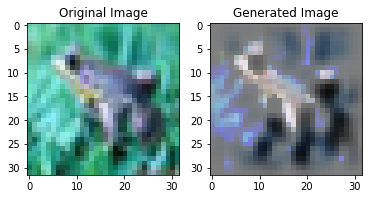

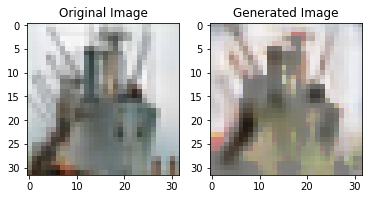

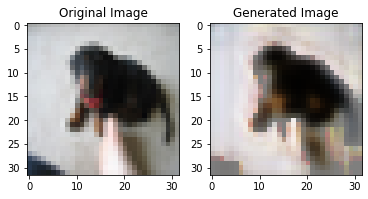

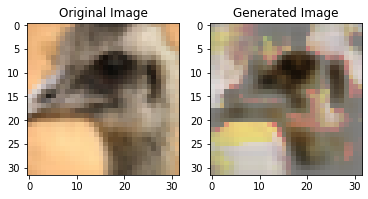

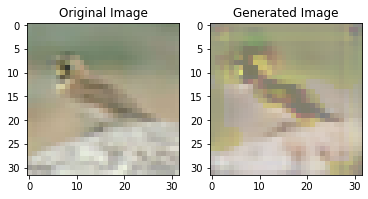

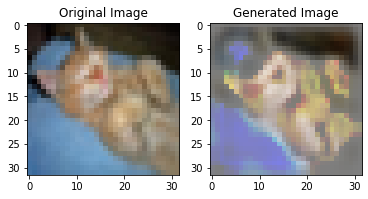

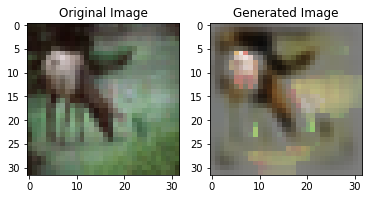

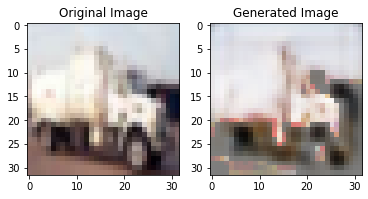

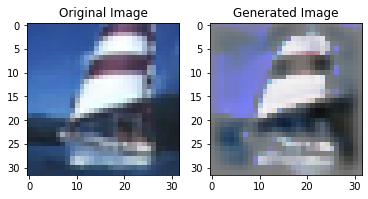

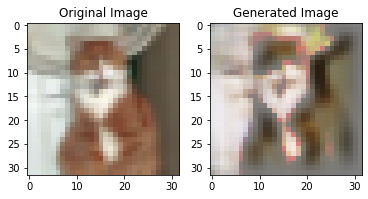

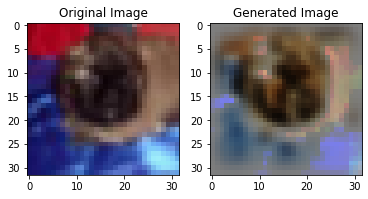

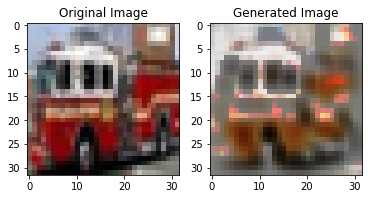

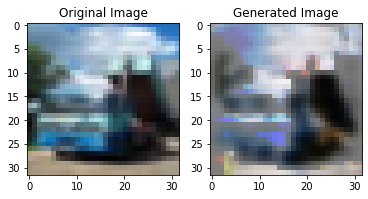

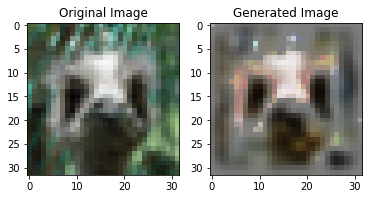

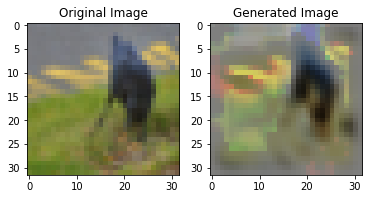

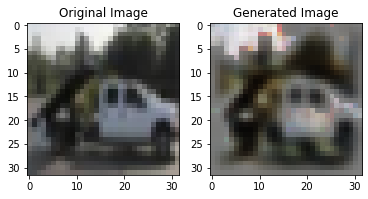

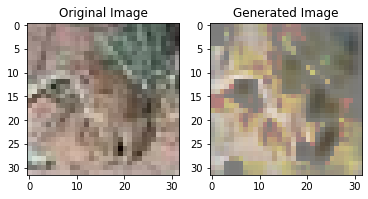

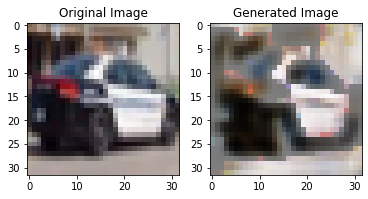

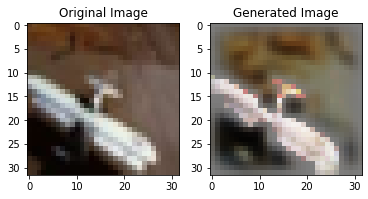

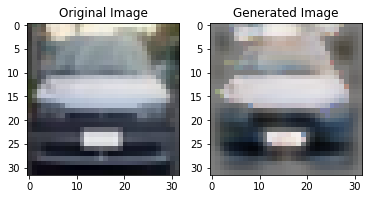

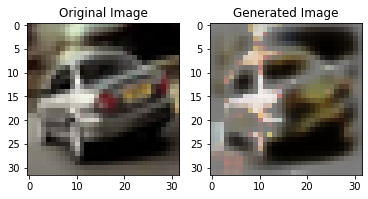

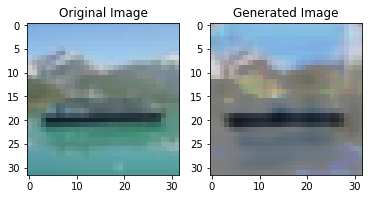

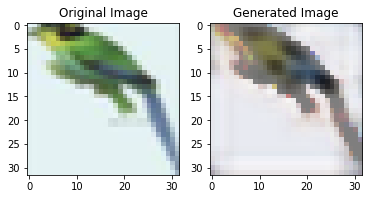

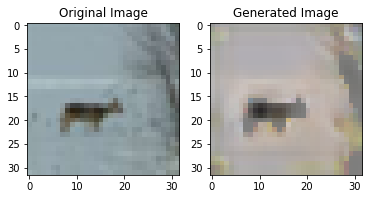

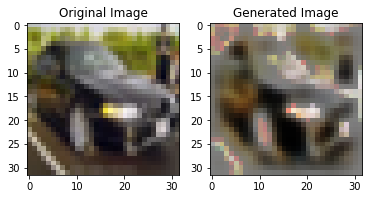

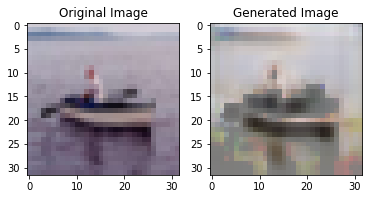

In [25]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model7(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed (two losses - no scaling of losses,feedback?)

In [8]:
model6 = Mixed().to(device)
#optimizer = optim.ASGD(model1.parameters(),lr=0.01)
#optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model6.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model6.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model6(images) #first pass
        generated_1,predicted_1 = model6(images-generated_0) #feedback loop
        for i in range(3):
          generated_1,predicted_1 = model6(images-generated_1)
          loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss1+loss2*0.7
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model6.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

RuntimeError: ignored

In [0]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model6(test_images) #first pass
generated_1,predicted_1 = model6(test_images-generated_0) #feedback loop
for i in range(3):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model6(test_images-generated_1)
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 7, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(test_images[i].cpu(),(1,2,0)))

    plot = fig.add_subplot(1, 7, 2)
    plot.set_title('Output from original image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(generated_0[i].cpu().detach(),(1,2,0)), cmap='gray')

    plot = fig.add_subplot(1, 7, 3)
    plot.set_title('Original minus first output ')
    imgplot = plt.imshow(np.transpose((test_images-generated_0)[i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 4)
    plot.set_title('(n-1) input ')
    imgplot = plt.imshow(np.transpose(inputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 5)
    plot.set_title('(n-1) output ')
    imgplot = plt.imshow(np.transpose(outputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 6)
    plot.set_title('Last input ')
    imgplot = plt.imshow(np.transpose(inputs[2][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(np.transpose(generated_1[i].cpu().detach(),(1,2,0)))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Average testing loss: 1.0686, test Accuracy: 6173/10000 (62%)


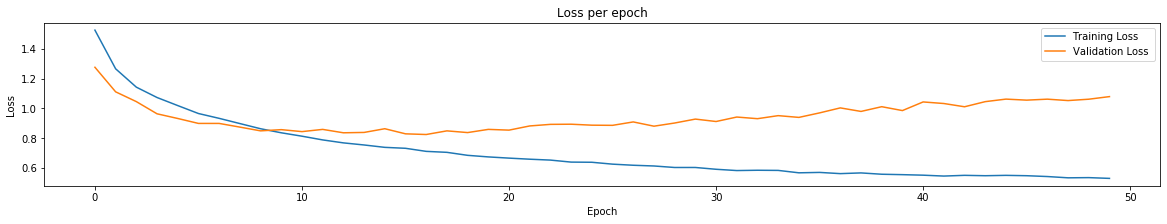

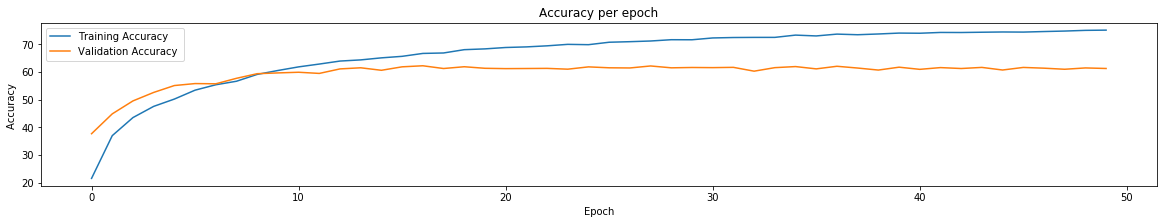

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model6.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            test_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [6]:
model9 = Mixed().to(device)
optimizer = optim.Adagrad(model9.parameters(),lr=0.01)
#optimizer = optim.ASGD(model9.parameters(),lr=0.01)
#optimizer = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model9.parameters(),lr=0.01)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model9.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model9(images) #first pass
        generated_1,predicted_1 = model9(images-generated_0*0.2) #feedback loop
        alpha = 0.3
        for i in range(3):
          generated_1,predicted_1 = model9(images-generated_1*alpha)
          alpha = alpha + 0.1
          #loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss2
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model9.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model9(images) #first pass
            generated_1,predicted_1 = model9(images-generated_0*0.4) #feedback loop
            alpha = 0.5
            for i in range(5):
                generated_1,predicted_1 = model9(images-generated_1*alpha)
                alpha = alpha + 0.1
                #loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss2
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 1.9639, Training Accuracy: 12531/40000 (31%)
Average validation loss: 1.6204, Validation Accuracy: 4129/10000 (41%)
Epoch 1
Average training loss: 1.4861, Training Accuracy: 18641/40000 (47%)
Average validation loss: 1.4377, Validation Accuracy: 4850/10000 (48%)
Epoch 2
Average training loss: 1.3169, Training Accuracy: 21208/40000 (53%)
Average validation loss: 1.3457, Validation Accuracy: 5068/10000 (51%)
Epoch 3
Average training loss: 1.1808, Training Accuracy: 23285/40000 (58%)
Average validation loss: 1.2697, Validation Accuracy: 5409/10000 (54%)
Epoch 4
Average training loss: 1.0548, Training Accuracy: 25197/40000 (63%)
Average validation loss: 1.2924, Validation Accuracy: 5487/10000 (55%)
Epoch 5
Average training loss: 0.9592, Training Accuracy: 26704/40000 (67%)
Average validation loss: 1.2049, Validation Accuracy: 5778/10000 (58%)
Epoch 6
Average training loss: 0.8555, Training Accuracy: 28042/40000 (70%)
Average validation loss: 1.2088, Validatio

KeyboardInterrupt: ignored

In [0]:
torch.cuda.empty_cache()

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")

In [7]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model9(test_images) #first pass
generated_1,predicted_1 = model9(test_images-generated_0*0.4) #feedback loop
alpha = 0.5
for i in range(5):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model9(test_images-generated_1*alpha)
    alpha = alpha + 0.1
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 8, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(test_images[i].cpu(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 2)
    plot.set_title('Output from original image ')
    imgplot = plt.imshow(np.transpose(generated_0[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 3)
    plot.set_title('Original minus first output ')
    imgplot = plt.imshow(np.transpose((test_images-generated_0)[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 4)
    plot.set_title('(n-1) input ')
    imgplot = plt.imshow(np.transpose(inputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 5)
    plot.set_title('(n-1) output ')
    imgplot = plt.imshow(np.transpose(outputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 6)
    plot.set_title('Last input ')
    imgplot = plt.imshow(np.transpose(inputs[2][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(np.transpose(generated_1[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 8)
    plot.set_title('Diff last two outputs ')
    normalized_output = generated_1[i].cpu().detach()-outputs[1][i].cpu().detach()
    imgplot = plt.imshow(np.transpose(normalized_output,(1,2,0)), cmap='gray')
    
    plt.show()

Output hidden; open in https://colab.research.google.com to view.